# Visualizing feature maps and activations

Using this dataset https://www.kaggle.com/c/flower-classification-with-tpus
and using https://nbviewer.jupyter.org/github/MicPie/fastai_course_v3/blob/master/L1-stonefly_activations_v2.ipynb and https://github.com/fastai/fastai2/blob/master/nbs/course/lesson6-pets-more.ipynb for inspiration

In [1]:
from fastai2.vision.all import *
import tensorflow as tf
import gc
from tfrecord.tfrecord import *
import kornia

In [2]:
path = Path('./data/flower224')

train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

data = []
for name in train_fnames+test_fnames:
    r = Reader(str(name), unpack_sample)
    for sample in r:
        data.append([sample['image'][0], sample['class'][0]])
        
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

def get_items(noop): return data
splitter = IndexSplitter(range(12753, len(data)))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [3]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[Resize(224)],
                  batch_tfms=[*aug_transforms()])

dls = block.dataloaders('', bs=16, num_workers=0)
net = xresnet50(pretrained=False, sa=True, act_cls=Mish)
learn = Learner(dls, net, metrics=accuracy)

In [4]:
learn.summary()

XResNet (Input shape: ['16 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 32 x 112 x 112  864        True      
________________________________________________________________
BatchNorm2d          16 x 32 x 112 x 112  64         True      
________________________________________________________________
Mish                 16 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               16 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          16 x 32 x 112 x 112  64         True      
________________________________________________________________
Mish                 16 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               16 x 64 x 112 x 112  18,432     True      
____________________________________________________

In [5]:
idx=0
x,y = dls.valid_ds[idx]

In [86]:
b = dls.one_batch()
xb_im = TensorImage(dls.train.decode(b)[0][0])
xb = b[0]

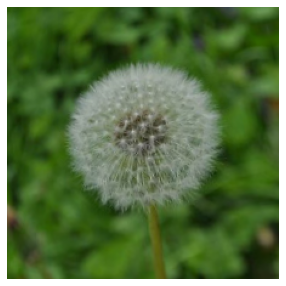

In [87]:
show_image(xb_im)

In [88]:
layers = flatten_model(learn.model)

In [89]:
custom_hook = hook_outputs(layers)

In [90]:
custom_hook.stored #inital are all empty

(#183) [None,None,None,None,None,None,None,None,None,None...]

In [91]:
learn.load('FastTen_Base') #load model

In [92]:
pre = learn.predict(xb_im)
pre[0]

'49'

In [93]:
custom_hook.stored #now has values for each layer

(#183) [tensor([[[[-0.4934, -0.3762, -0.3615,  ..., -0.5692, -0.5155, -0.4817],
          [-0.6103, -0.3870, -0.3380,  ..., -0.2227, -0.2413, -0.2443],
          [-0.6378, -0.4092, -0.3526,  ..., -0.1958, -0.2197, -0.2382],
          ...,
          [-0.6174, -0.3354, -0.3392,  ..., -0.0929, -0.1424, -0.1602],
          [-0.5978, -0.3332, -0.3323,  ..., -0.0678, -0.1256, -0.1425],
          [-0.5940, -0.3187, -0.2932,  ..., -0.1075, -0.1671, -0.2177]],

         [[-0.0462,  0.3151,  0.3550,  ...,  0.7646,  0.6636,  0.5765],
          [-0.3207, -0.0057,  0.0520,  ...,  0.0322,  0.0393,  0.0090],
          [-0.2883,  0.0772,  0.0984,  ..., -0.0052,  0.0124,  0.0373],
          ...,
          [-0.4405, -0.0794, -0.0819,  ..., -0.0441, -0.1271, -0.1449],
          [-0.3901, -0.0567, -0.0615,  ..., -0.0639, -0.1184, -0.1531],
          [-0.3402, -0.0212, -0.0545,  ...,  0.0077,  0.0050, -0.0344]],

         [[ 0.1182,  0.3114,  0.3064,  ...,  0.3060,  0.3053,  0.2978],
          [-0.1917,  0

In [94]:
m = learn.model.eval();
m

XResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [95]:
m[0][0]

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

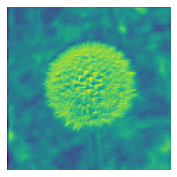

In [96]:
r = custom_hook.stored[0][0][0] # get values for first conv2d layer
e = TensorImage(r) #convert to TensorImage
show_image(e)

In [107]:
#from https://github.com/fastai/fastai2/blob/master/nbs/course/lesson6-pets-more.ipynb
#get heatmap activations
def hooked_backward(cat=y):
    with hook_output(m[0][0]) as hook_a: 
        with hook_output(m[0][0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()
activations  = hook_a.stored[0].cpu()
gradients = hook_g.stored[0][0].cpu()
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
acts  = hook_a.stored[0].cpu()
mult = (acts*grad_chan[...,None,None]).mean(0)

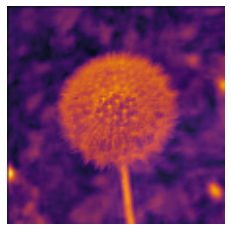

In [108]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ctx=ax)
    ax.imshow(hm, alpha=0.9,
              interpolation='bilinear', cmap='inferno');

show_heatmap(mult)

In [105]:
def v():
    i = 16
    layer = (f'conv2b_{i}')
    r = custom_hook.stored[i][0][0] # get values for first conv2d layer
    e = TensorImage(r)
    
    def hooked_backward(cat=y):
        with hook_output(m[5][0]) as hook_a: 
            with hook_output(m[5][0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    
    hook_a,hook_g = hooked_backward()
    activations  = hook_a.stored[0].cpu()
    gradients = hook_g.stored[0][0].cpu()
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    acts  = hook_a.stored[0].cpu()
    mult = (acts*grad_chan[...,None,None]).mean(0)
    
    _,axs = subplots(1, 2, figsize=(10,10))
    print(layer)
    TensorImage(r).show(ctx=axs[0], title='feature_map')
    TensorImage(mult).show(ctx=axs[1], alpha=0.9, interpolation='bilinear', cmap='inferno', title='heat_map')

conv2b_0


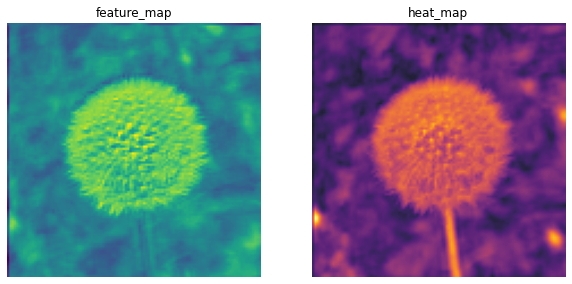

In [98]:
v() #First Conv2d layer

conv2b_3


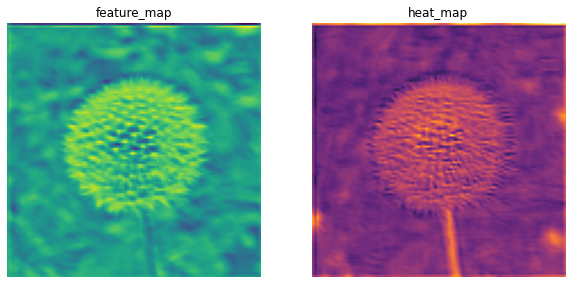

In [100]:
v() #Second Conv2d layer

conv2b_6


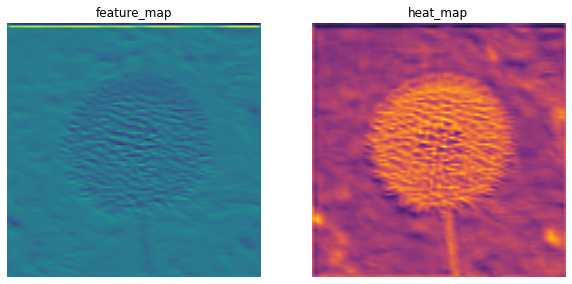

In [102]:
v() #Third Conv2d layer

conv2b_10


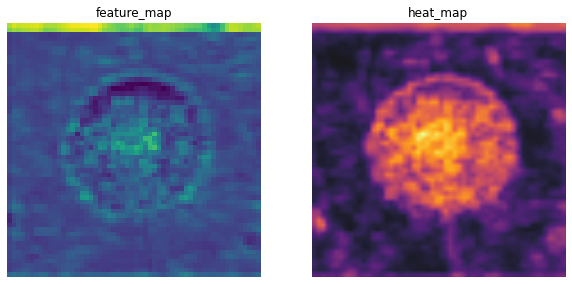

In [104]:
v() #Forth Conv2d layer

conv2b_16


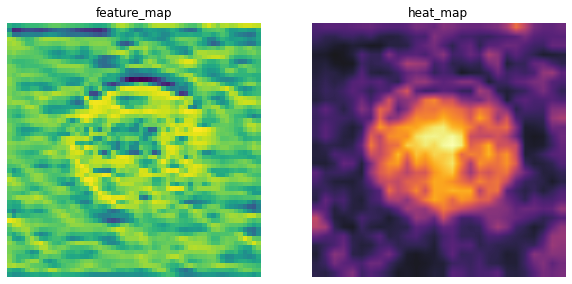

In [106]:
v() #Fifth Conv2d layer

In [109]:
def v2():
    for i in range(0,8,1):
    #i = 0
        layer = (f'conv2b_{i}')
        r = custom_hook.stored[i][0][0] # get values for first conv2d layer
        e = TensorImage(r)
    
        def hooked_backward(cat=y):
            with hook_output(m[i]) as hook_a: 
                with hook_output(m[i], grad=True) as hook_g:
                    preds = m(xb)
                    preds[0,int(cat)].backward()
            return hook_a,hook_g
    
        hook_a,hook_g = hooked_backward()
        activations  = hook_a.stored[0].cpu()
        gradients = hook_g.stored[0][0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        acts  = hook_a.stored[0].cpu()
        mult = (acts*grad_chan[...,None,None]).mean(0)
    
        _,axs = subplots(1, 2, figsize=(10,10))
        _.suptitle(layer)
        TensorImage(r).show(ctx=axs[0], title='feature_map')
        TensorImage(mult).show(ctx=axs[1], alpha=0.9, interpolation='bilinear', cmap='inferno', title='heat_map')

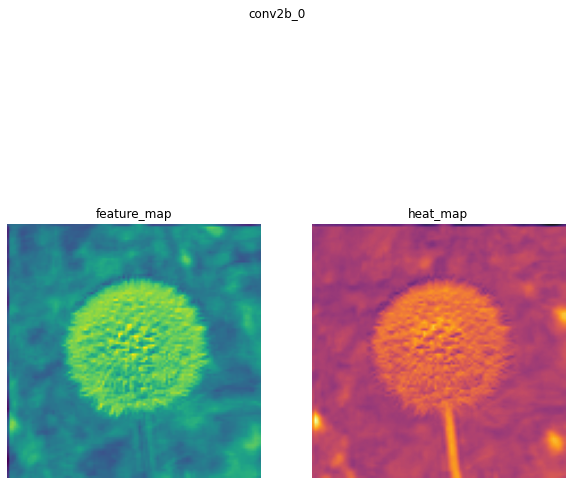

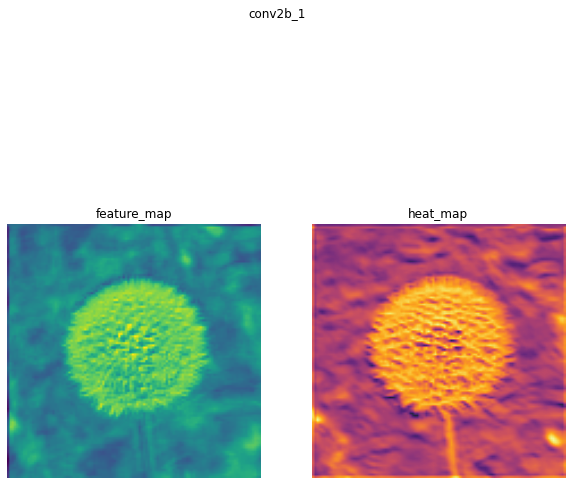

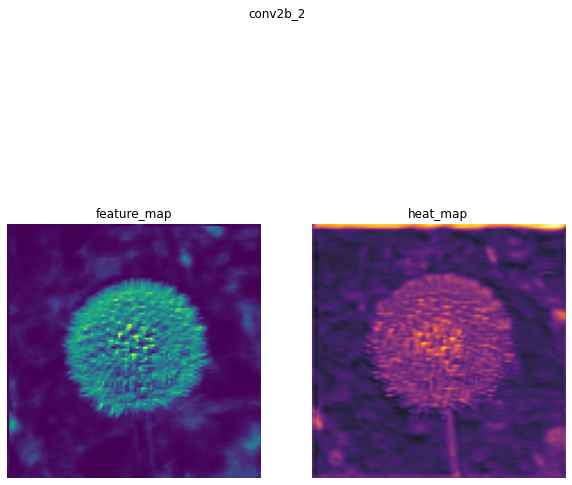

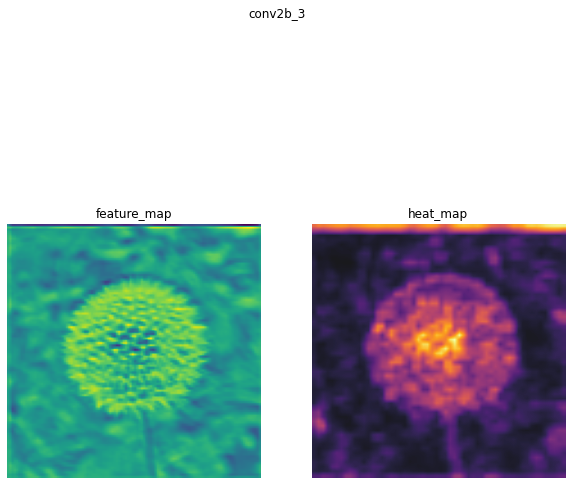

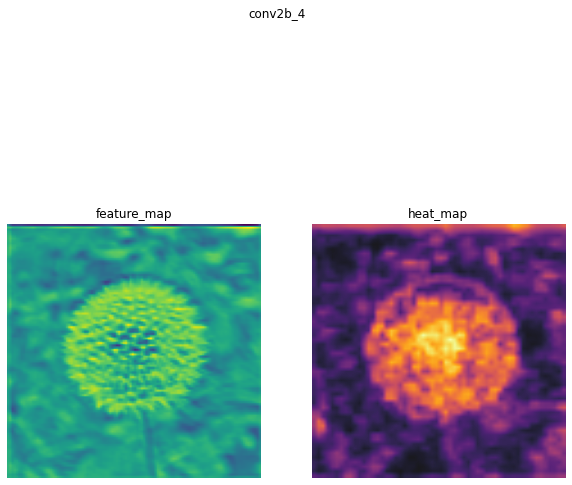

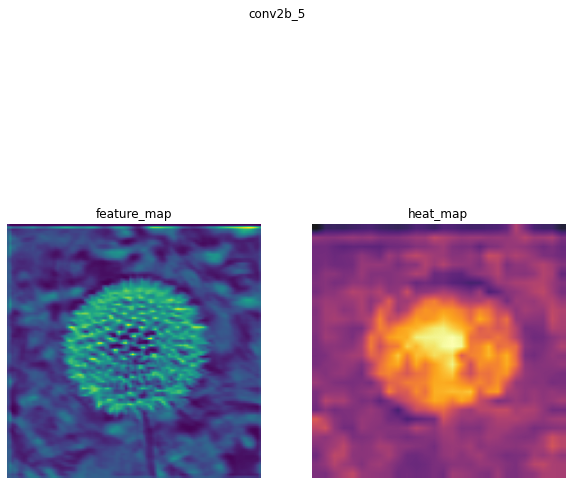

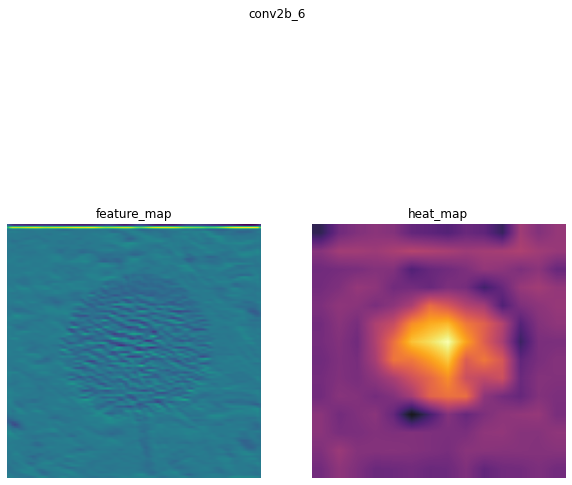

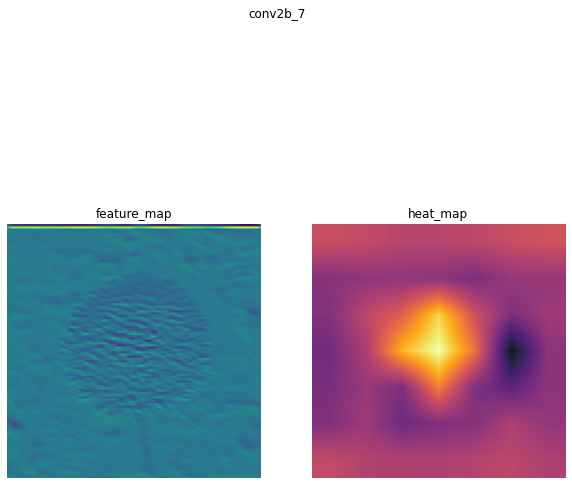

In [110]:
v2()